In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# 원본 데이터
raw_data = pd.read_csv("uci-secom.csv")

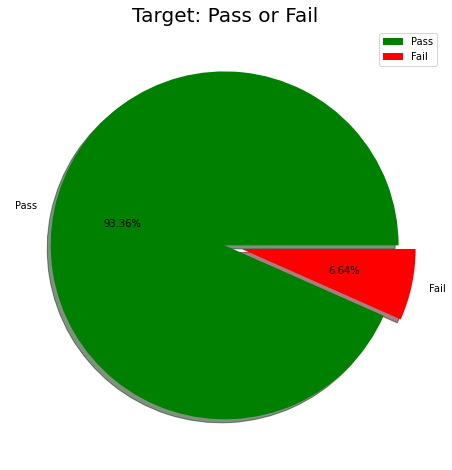

In [3]:
# 데이터 시각화(클래스 불균형)
labels = ['Pass', 'Fail']
size = raw_data['Pass/Fail'].value_counts()
colors = ['green', 'red']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlation')

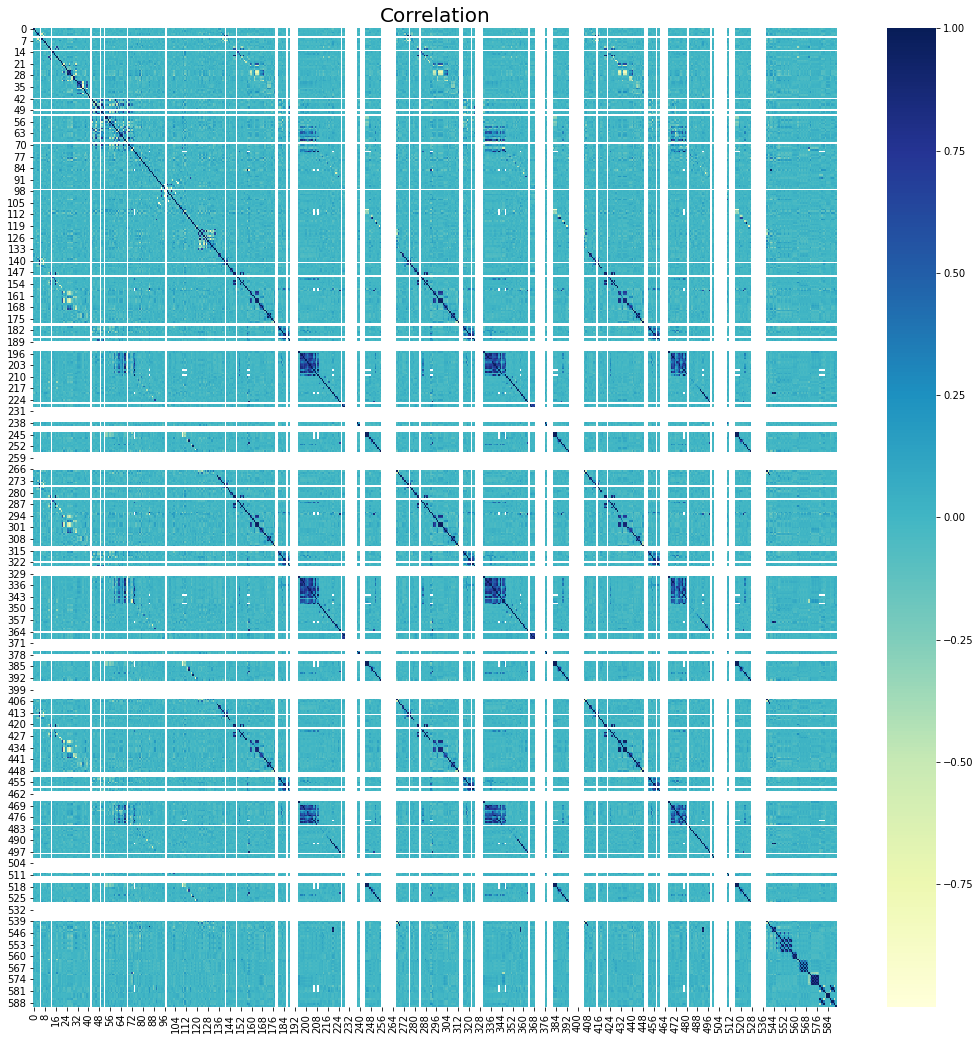

In [4]:
# 데이터 시각화(클래스 불균형)
plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(raw_data.corr(), cmap = "YlGnBu")
plt.title('Correlation', fontsize = 20)

In [5]:
# 데이터 크기 확인
data_count = raw_data.shape[0]

# 종속 변수
result = raw_data["Pass/Fail"]
# 시계열 특성 데이터라고 가정하지 않으므로 Time 속성 제거
shrinked_data = raw_data.drop(["Time"], axis=1)
shrinked_data = shrinked_data.drop(["Pass/Fail"], axis=1)

# 전체의 50% 이상이 null 값을 가진 특성 제거
shrinked_data = shrinked_data.loc[:, (raw_data.isna().sum(axis=0) <= data_count * 0.5)]

# 특성의 모든 값이 상수를 가진 특성을 제거
shrinked_data = shrinked_data.loc[:, (raw_data.var(axis=0) != 0)]

# 독립 변수끼리의 상관 관계가 높은 항목을 제거
corr_matrix = shrinked_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

shrinked_data.drop(to_drop, axis=1, inplace=True)

In [6]:
# K개의 이웃을 통해 결측치를 예측
imputer = KNNImputer(n_neighbors=5)
imputed_data = pd.DataFrame(imputer.fit_transform(shrinked_data),columns = shrinked_data.columns)

In [7]:
# 각 특성의 스케일을 맞춤
scaled_data = pd.DataFrame(StandardScaler().fit_transform(imputed_data))

In [8]:
# SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
smote = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(scaled_data, result,test_size=0.25,random_state=10)
X_train_over,y_train_over = smote.fit_resample(X_train, y_train)